In [69]:
import math
import random
import numpy as np
import matplotlib.pyplot as plt

from graphviz import Digraph

# One input derivative

In [22]:
def f(x):
    return 3*x**2 - 4*x + 5

In [23]:
xx = np.arange(-5, 5, 0.25)
xx

array([-5.  , -4.75, -4.5 , -4.25, -4.  , -3.75, -3.5 , -3.25, -3.  ,
       -2.75, -2.5 , -2.25, -2.  , -1.75, -1.5 , -1.25, -1.  , -0.75,
       -0.5 , -0.25,  0.  ,  0.25,  0.5 ,  0.75,  1.  ,  1.25,  1.5 ,
        1.75,  2.  ,  2.25,  2.5 ,  2.75,  3.  ,  3.25,  3.5 ,  3.75,
        4.  ,  4.25,  4.5 ,  4.75])

In [24]:
yy = f(xx)
yy

array([100.    ,  91.6875,  83.75  ,  76.1875,  69.    ,  62.1875,
        55.75  ,  49.6875,  44.    ,  38.6875,  33.75  ,  29.1875,
        25.    ,  21.1875,  17.75  ,  14.6875,  12.    ,   9.6875,
         7.75  ,   6.1875,   5.    ,   4.1875,   3.75  ,   3.6875,
         4.    ,   4.6875,   5.75  ,   7.1875,   9.    ,  11.1875,
        13.75  ,  16.6875,  20.    ,  23.6875,  27.75  ,  32.1875,
        37.    ,  42.1875,  47.75  ,  53.6875])

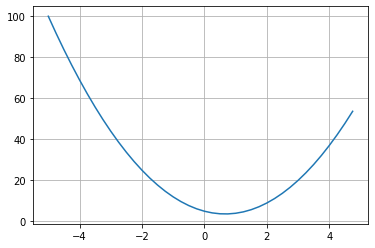

In [25]:
plt.plot(xx, yy)
plt.grid(which="major")

In [26]:
h = 0.001
x = 2/3

(f(x+h) - f(x)) / h

0.0029999999995311555

# Multiple input derivative

In [27]:
a = 2.0
b = -3.0
c = 10.0
d = a * b + c
d

4.0

In [28]:
h = 0.0001

a = 2.0
b = -3.0
c = 10.0

d1 = a*b + c
c += h
d2 = a*b + c

print(d1)
print(d2)
print("slope", (d2-d1)/h)


4.0
4.0001
slope 0.9999999999976694


# MicroGrad

In [29]:
class Value:
    def __init__(self, data, _children=(), _op=(), label=''):
        self.data = data
        self._prev = set(_children)
        self._op = _op
        self.label=label
        self.grad = 0.0

    def __add__(self, other):
        out = Value(self.data + other.data, _children=(self, other), _op="+")
        return out

    def __mul__(self, other):
        out = Value(self.data * other.data, _children=(self, other), _op="*")
        return out

    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1) / (math.exp(2*x) + 1)
        out = Value(t, _children=(self,), _op="tanh")
        return out    

    def __repr__(self):
        return f"Value(data={self.data})"  

In [30]:
a = Value(2., label='a')
b = Value(-3., label='b')
c = Value(10., label='c')
e = a*b; e.label='e'
d = e + c; d.label='d'
g = Value(-2.0, label='g')
L = g * d
L.label = 'L'

In [31]:
d = a*b + c
d

Value(data=4.0)

In [32]:
def trace(root):
    nodes, edges = set(), set()

    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)        
    return nodes, edges    

In [33]:
def draw_dot(root):
    dot = Digraph(format='svg', graph_attr={"rankdir":"LR"})

    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))

        dot.node(name=uid, label="%s | data %.4f | grad %.4f" % (n.label, n.data, n.grad), shape="record")

        if n._op:
            dot.node(name=uid+n._op, label=n._op)
            dot.edge(uid+n._op, uid)


    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)

    return dot            

In [34]:
def lol():
    h = 0.001

    a = Value(2., label='a')
    b = Value(-3., label='b')
    c = Value(10., label='c')
    e = a*b; e.label='e'
    d = e + c; d.label='d'
    g = Value(-2.0, label='g')
    L = g * d; L.label="L"
    L1 = L.data

    a = Value(2., label='a')
    b = Value(-3., label='b')
    b.data += h
    c = Value(10., label='c')
    e = a*b; e.label='e'
    d = e + c; d.label='d'
    g = Value(-2.0, label='g')
    L = g * d; L.label="L"
    L2 = L.data


    print((L2 - L1)/h)


lol()        

-3.9999999999995595


In [35]:
L.grad = 1
d.grad = -2
g.grad = 4
e.grad = -2
c.grad = -2
a.grad = 6
b.grad = -4


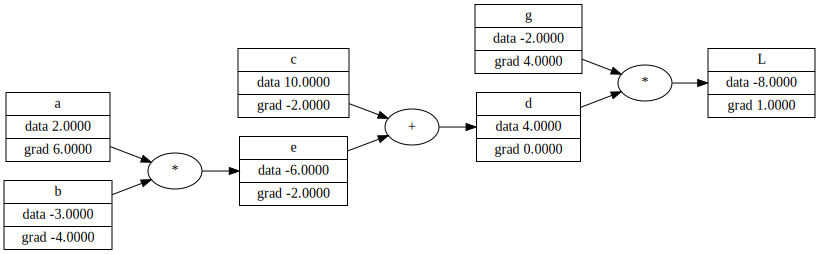

In [36]:
draw_dot(L)

In [37]:
L.data

-8.0

In [38]:
a.data = a.data + 0.01*a.grad
b.data = b.data + 0.01*b.grad
c.data = c.data + 0.01*c.grad
g.data = g.data + 0.01*g.grad

In [39]:
e = a * b
d = e + c
L = g * d

In [40]:
L.data

-7.286496

# Backprop through a neuron

In [41]:
class Value:
    def __init__(self, data, _children=(), _op=(), label=''):
        self.data = data
        self._backward = lambda: None
        self._prev = set(_children)
        self._op = _op
        self.label=label
        self.grad = 0.0

    def __add__(self, other):
        out = Value(self.data + other.data, _children=(self, other), _op="+")

        def _backward():
            self.grad = 1 * out.grad 
            other.grad = 1 * out.grad 

        out._backward = _backward
        return out

    def __mul__(self, other):
        out = Value(self.data * other.data, _children=(self, other), _op="*")

        def _backward():
            self.grad = other.data * out.grad
            other.grad = self.data * out.grad

        out._backward = _backward
        return out

    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1) / (math.exp(2*x) + 1)
        out = Value(t, _children=(self,), _op="tanh")

        def _backward():
            self.grad = (1 - t**2) * out.grad

        out._backward = _backward
        return out    


    def backward(self):
        # topological sort
        topo = []
        visited = set()

        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)  

        build_topo(self)
        self.grad = 1.

        for node in reversed(topo):
            node._backward()


    def __repr__(self):
        return f"Value(data={self.data})"  

In [42]:
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

b = Value(6.88, label='b')

x1w1 = x1 * w1; x1w1.label = "x1w1"
x2w2 = x2 * w2; x2w2.label = "x2w2"
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = "x1w1x2w2"
n = x1w1x2w2 + b; n.label = "n"
o = n.tanh(); o.label="o"

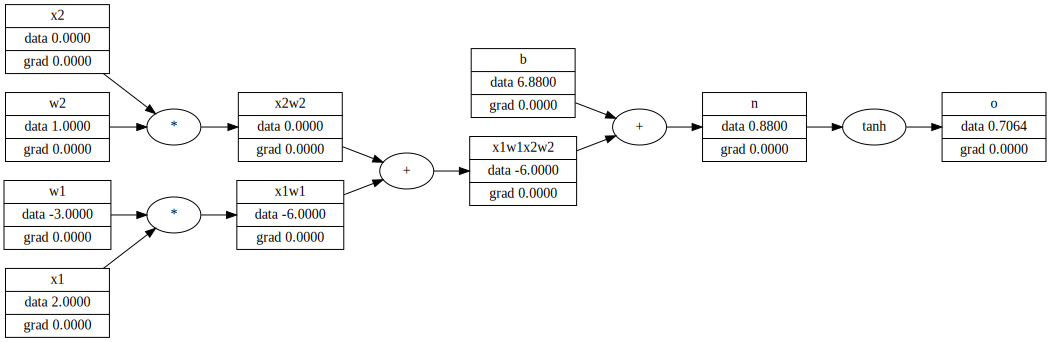

In [43]:
draw_dot(o)

In [44]:
o.grad = 1.

In [45]:
# automatic
o.grad = 1.
o._backward()
n._backward()
x1w1x2w2._backward()
x2w2._backward()
x1w1._backward()


In [46]:
# manually
o.grad = 1.

# 1 - tanh**2 = 1-o**2
n.grad = 1 - o.data**2
b.grad = 0.5

x1w1.grad = 0.5
x2w2.grad = 0.5

x1.grad = 0.5 * w1.data
w1.grad = 0.5 * x1.data

x2.grad = 0.5 * w2.data
w2.grad = 0.5 * x2.data

In [47]:
def numerical_check():
    x1 = Value(2.0, label='x1')
    x2 = Value(0.0, label='x2')

    w1 = Value(-3.0, label='w1')
    w2 = Value(1.0, label='w2')

    b = Value(6.88, label='b')

    x1w1 = x1 * w1; x1w1.label = "x1w1"
    x2w2 = x2 * w2; x2w2.label = "x2w2"
    x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = "x1w1x2w2"
    n = x1w1x2w2 + b; n.label = "n"
    o = n.tanh(); o.label="o"
    L1 = o.data

    h = 0.001

    x1 = Value(2.0, label='x1')
    
    x2 = Value(0.0, label='x2')

    w1 = Value(-3.0, label='w1')
    w2 = Value(1.0, label='w2')

    b = Value(6.88, label='b')

    x1w1 = x1 * w1; x1w1.label = "x1w1"
    x2w2 = x2 * w2; x2w2.label = "x2w2"
    x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = "x1w1x2w2"
    n = x1w1x2w2 + b; n.label = "n"
    n.data += h
    o = n.tanh(); o.label="o"
    L2 = o.data

    print((L2 - L1)/h)


In [48]:
numerical_check()

0.5006179307184278


In [49]:
# topological sort
topo = []
visited = set()

def build_topo(v):
    if v not in visited:
        visited.add(v)
        for child in v._prev:
            build_topo(child)
        topo.append(v)  


build_topo(o)
topo          

[Value(data=6.88),
 Value(data=1.0),
 Value(data=0.0),
 Value(data=0.0),
 Value(data=2.0),
 Value(data=-3.0),
 Value(data=-6.0),
 Value(data=-6.0),
 Value(data=0.8799999999999999),
 Value(data=0.7064193203972352)]

In [50]:
o.backward()

# Breaking up the Tanh

In [51]:
class Value:
    def __init__(self, data, _children=(), _op=(), label=''):
        self.data = data
        self._backward = lambda: None
        self._prev = set(_children)
        self._op = _op
        self.label=label
        self.grad = 0.0

    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, _children=(self, other), _op="+")

        def _backward():
            self.grad += 1 * out.grad 
            other.grad += 1 * out.grad 

        out._backward = _backward
        return out


    def __radd__(self, other):
        return self + other


    def __neg__(self):
        return -1 * self


    def __sub__(self, other):
        return self + (-other)    


    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, _children=(self, other), _op="*")

        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad

        out._backward = _backward
        return out


    def __rmul__(self, other):
        return self * other 


    def __truediv__(self, other):
        return self * (other**(-1))     


    def exp(self):
        out = Value(math.exp(self.data), _children=(self,), _op="exp")

        def _backward():
            self.grad += out.data * out.grad

        out._backward = _backward
        return out    

    def __pow__(self, other):
        assert isinstance(other, (int, float)), "power must be int, float"

        out = Value(math.pow(self.data, other), _children=(self, other), _op=f"pow_{other}")

        def _backward():
            # self.grad += out.grad * other * math.pow(self.data, other - 1)
            self.grad += other * (self.data**(other - 1)) * out.grad

        out._backward = _backward    
        return out    


    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1) / (math.exp(2*x) + 1)
        out = Value(t, _children=(self,), _op="tanh")

        def _backward():
            self.grad += (1 - t**2) * out.grad

        out._backward = _backward
        return out        


    def backward(self):
        # topological sort
        topo = []
        visited = set()

        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)  

        build_topo(self)
        self.grad = 1.

        for node in reversed(topo):
            node._backward()


    def __repr__(self):
        return f"Value(data={self.data})"  

In [52]:
a = Value(2.)
b = Value(4.)

In [53]:
s = a ** 2
s

Value(data=4.0)

In [54]:
a / b

Value(data=0.5)

In [55]:
a**2

Value(data=4.0)

In [56]:
a - b

Value(data=-2.0)

In [57]:
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

b = Value(6.88, label='b')

x1w1 = x1 * w1; x1w1.label = "x1w1"
x2w2 = x2 * w2; x2w2.label = "x2w2"
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = "x1w1x2w2"
n = x1w1x2w2 + b; n.label = "n"
# o = n.tanh(); o.label="o"

In [58]:
o = n**4

In [59]:
draw_dot(o)

AttributeError: 'int' object has no attribute '_prev'

In [60]:
o.backward()

AttributeError: 'int' object has no attribute '_prev'

In [70]:
n

Value(data=0.8799999999999999)

In [62]:
a.exp().backward()

In [63]:
a

Value(data=2.0)

# Torch Autograd

In [64]:
import torch

In [65]:
x1 = torch.tensor([2.], dtype=torch.float64, requires_grad=True)
w1 = torch.tensor([-3.], dtype=torch.float64, requires_grad=True)
x2 = torch.tensor([0.], dtype=torch.float64, requires_grad=True)
w2 = torch.tensor([1.], dtype=torch.float64, requires_grad=True)
b = torch.tensor([6.88], dtype=torch.float64, requires_grad=True)

In [66]:
n = x1*w1 + x2*w2 + b
o = torch.tanh(n)

In [67]:
o

tensor([0.7064], dtype=torch.float64, grad_fn=<TanhBackward0>)

In [68]:
o.backward()

In [105]:
class Neuron:
    def __init__(self, n_input):
        self.w = [Value(data=random.uniform(-1,1)) for _ in range(n_input)]
        self.b = Value(data=random.uniform(-1,1))

    def __call__(self, x):
        act = sum((w_i * x_i for w_i, x_i in list(zip(self.w, x))), self.b)
        out = act.tanh()

        return out  

    def parameters(self):
        return self.w + [self.b]



class Layer:
    def __init__(self, n_input, n_output):
        self.neurons = [Neuron(n_input) for _ in range(n_output)]

    def __call__(self, x):
        outs = [neuron(x) for neuron in self.neurons]

        return outs[0] if len(outs) == 1 else outs

    def parameters(self):
        return [param for neuron in self.neurons for param in neuron.parameters()]   


class MLP:
    def __init__(self, n_input, n_output):
        all_sizes = [n_input] + n_output
        self.layers = [Layer(all_sizes[i], all_sizes[i+1]) for i in range(len(n_output))]

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x) 

        return x   

    def parameters(self):
        return [param for layer in self.layers for param in layer.parameters()]              


x = [2., 3.]
n = MLP(2, [4, 4, 1])
n(x)        

Value(data=-0.2292095535177093)

In [83]:
draw_dot(n)

AttributeError: 'MLP' object has no attribute '_prev'

In [91]:
xs = [
    [2., 3., -1.],
    [3., -1., 0.5],
    [0.5, 1., 1.],
    [1., 1., -1.]
]

ys = [1., -1, -1., 1.]
y_pred = [n(x) for x in xs]
y_pred

[Value(data=-0.2097176506438344),
 Value(data=-0.8104260798092614),
 Value(data=-0.31186305698024425),
 Value(data=-0.33094656993183047)]

In [96]:
loss = sum((y_p - y_t)**2 for y_p, y_t in zip(y_pred, ys)) / len(y_pred)
loss

Value(data=0.9360765724644006)

In [97]:
loss.backward()

AttributeError: 'int' object has no attribute '_prev'

In [107]:
len(n.parameters())

37

In [110]:
lr = 0.01

In [112]:
for p in n.parameters():
    p.data += -lr * p.grad

In [116]:
for k in range(10):

    # forward pass
    y_pred = [n(x) for x in xs]
    loss = sum((y_p - y_t)**2 for y_p, y_t in zip(y_pred, ys)) / len(y_pred)

    # backward pass
    for p in n.parameters():
        p.grad = 0.

    loss.backward()

    # update params
    for p in n.parameters():
        p.data += -lr * p.grad

    print(k, loss.data)    


    
    

AttributeError: 'int' object has no attribute '_prev'